In [70]:
import time

import matplotlib.pyplot as plt
import tensorflow as tf
from tfdiffeq import odeint
from tfdiffeq import plot_phase_portrait, plot_vector_field, plot_results

NUM_SAMPLES = 1000
device = 'cpu:0'

# Force Float 64
tf.keras.backend.set_floatx('float64')



In [71]:
class LotkaVoltera(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.b, self.c, self.d = a, b, c, d
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)
    
    dR_dT = self.a * r - self.b * r * f
    dF_dT = -self.c * f + self.d * r * f
    
    return tf.stack([dR_dT, dF_dT])

In [72]:
t = tf.linspace(0., 10., num=NUM_SAMPLES)
initial_states = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

In [73]:
with tf.device(device):
  result = odeint(LotkaVoltera(a, b, c, d), initial_states, t)
  
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (1000, 2)


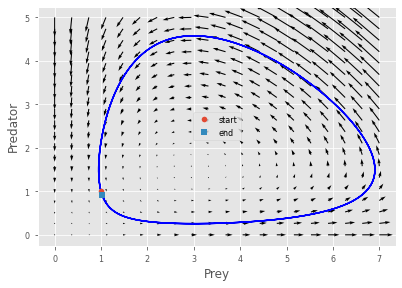

In [74]:
lims = [0, 5]
plot_phase_portrait(LotkaVoltera(a, b, c, d), xlabel='Prey', ylabel='Predator', xlims=[0, 7], ylims=lims)
plot_vector_field(result, xlabel='Prey', ylabel='Predator')

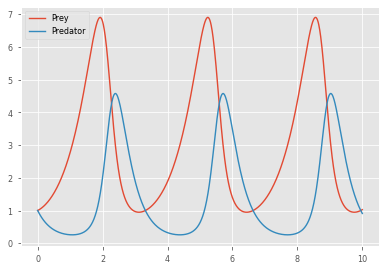

In [75]:
plot_results(t, result, labels=['Prey', 'Predator'])

In [103]:
class LotkaVolteraTrainable(tf.keras.Model):
  
  def __init__(self, a, b, c, d, **kwargs):
    super().__init__(**kwargs)
    
    self.a, self.c = a, c

    self.eqn = tf.keras.Sequential([
             tf.keras.layers.Dense(32, activation=tf.nn.swish, input_shape=(2,)),
             tf.keras.layers.Dense(32, activation=tf.nn.swish,),
             tf.keras.layers.Dense(32, activation=tf.nn.swish),
             tf.keras.layers.Dense(2, activation='relu',)   
    ])
  
  @tf.function
  def call(self, t, y):
    # y = [R, F]
    r, f = tf.unstack(y)

    # Neural ODE component
    n_out = self.eqn(tf.reshape(y, [1, 2]))  # [1, 2] -> [1, 2]
    pred1 = n_out[0, 0]
    pred2 = n_out[0, 1]
    
    dR_dT = self.a * r - pred1
    dF_dT = -self.c * f + pred2
    
    return tf.stack([dR_dT, dF_dT])

In [77]:
t_train = tf.linspace(0., 2., num=30)  # Train for just 2 seconds of input
initial_states_train = tf.convert_to_tensor([1, 1], dtype=tf.float64)

a = 1.5
b = 1
c = 3
d = 1

epochs = 100
initial_learning_rate = 0.01
decay_steps = 100
decay_rate = 0.5

In [78]:
from tensorflow.keras import backend as K
K.clear_session()

In [79]:
start = time.time()
with tf.device(device):
  model = LotkaVolteraTrainable(a, b, c, d)

  learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False,
  )

  optimizer = tf.keras.optimizers.Adam(learning_rate)

  print("Computing ground truth...")
  y_real = odeint(LotkaVoltera(a, b, c, d), initial_states_train, t_train)

  print("Ground truth shape :", y_real.shape)

  for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")

    with tf.GradientTape() as tape:
      preds = odeint(model, initial_states_train, t_train)
      loss = tf.reduce_mean(tf.square(y_real - preds), axis=1)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    print("Loss :", loss.numpy().mean())
    print("LR :", learning_rate(optimizer.iterations).numpy())
    print()
end = time.time()
time_elapsed = end-start
print("Time elapsed: %f s" % time_elapsed)

Computing ground truth...
Ground truth shape : (30, 2)
Epoch 1
Loss : 10.989042237653447
LR : 0.0099309245

Epoch 2
Loss : 3.0185898087542187
LR : 0.009862327

Epoch 3
Loss : 0.3245708998022577
LR : 0.009794203

Epoch 4
Loss : 0.46390713075008105
LR : 0.0097265495

Epoch 5
Loss : 1.170833659806103
LR : 0.009659363

Epoch 6
Loss : 1.426535397350246
LR : 0.009592641

Epoch 7
Loss : 1.2181285171779668
LR : 0.009526379

Epoch 8
Loss : 0.7546748276116062
LR : 0.009460577

Epoch 9
Loss : 0.2990722495950725
LR : 0.009395227

Epoch 10
Loss : 0.14749680031154205
LR : 0.0093303295

Epoch 11
Loss : 0.4366103329208553
LR : 0.00926588

Epoch 12
Loss : 0.6668404816369355
LR : 0.009201876

Epoch 13
Loss : 0.5162738338672533
LR : 0.009138315

Epoch 14
Loss : 0.2514457279265691
LR : 0.009075192

Epoch 15
Loss : 0.1069467373879804
LR : 0.0090125045

Epoch 16
Loss : 0.11100412103565986
LR : 0.00895025

Epoch 17
Loss : 0.18762778610902278
LR : 0.008888427

Epoch 18
Loss : 0.2586571438458624
LR : 0.0088270

In [80]:
from tfdiffeq.bfgs_optimizer import BFGSOptimizer

In [81]:
tolerance = 1e-6
bfgs_optimizer = BFGSOptimizer(max_iterations=50, tolerance=tolerance)

In [82]:
from tfdiffeq.adjoint import odeint as adjoint_odeint

def loss_wrapper(model):
  # Can use `adjoing_odeint` here as replacement for `adjoint_odeint`
  preds = odeint(model, initial_states_train, t_train, atol=1e-6, rtol=1e-6)
  loss = tf.reduce_mean(tf.square(y_real - preds))
  return loss



In [83]:
start = time.time()
model = bfgs_optimizer.minimize(loss_wrapper, model)
end = time.time()
time_elapsed = end - start
print("Time Elapsed: %f" % time_elapsed)

Iter: 1 loss: 0.042885550255246346
Iter: 2 loss: 0.051487889963582639
Iter: 3 loss: 0.04282305352276157
Iter: 4 loss: 0.039466061158760071
Iter: 5 loss: 0.11496901658206067
Iter: 6 loss: 0.039311384652547368
Iter: 7 loss: 0.031754697597266596
Iter: 8 loss: 0.031544262847573536
Iter: 9 loss: 0.54839595604289
Iter: 10 loss: 0.03046906880971886
Iter: 11 loss: 0.061274609366494107
Iter: 12 loss: 0.027887406901078347
Iter: 13 loss: 3818.2199123864125
Iter: 14 loss: 0.027887366830074568
Iter: 15 loss: 0.5898435566634106
Iter: 16 loss: 0.027272207582444578
Iter: 17 loss: 0.26059784037975053
Iter: 18 loss: 0.038316014325287161
Iter: 19 loss: 0.025210377791662027
Iter: 20 loss: 0.080340568546533334
Iter: 21 loss: 0.023848753755771633
Iter: 22 loss: 0.039995920095875409
Iter: 23 loss: 0.021923442042172846
Iter: 24 loss: 0.029991305841439417
Iter: 25 loss: 0.018589503633702955
Iter: 26 loss: 0.027915103844694963
Iter: 27 loss: 0.01622620949366026
Iter: 28 loss: 0.042739194480233264
Iter: 29 loss:

In [84]:
#Interpolating
t_eval = tf.linspace(0., 2, num=1000)  # Re-evaluate for just 2 seconds of input, but 1000 timesteps

with tf.device(device):
    model_results = odeint(model, initial_states, t_eval)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states, t_eval)

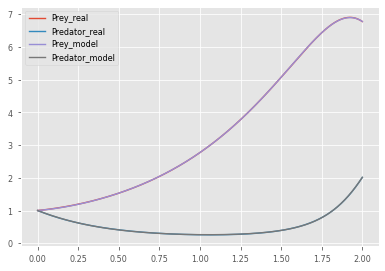

In [85]:
plot_results(t_eval, real_results, labels=['Prey_real', 'Predator_real'])
plot_results(t_eval, model_results, labels=['Prey_model', 'Predator_model'])

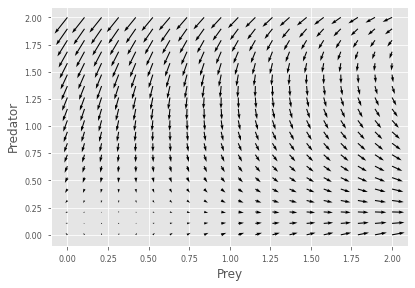

In [86]:
lims = [0, 2]
plot_phase_portrait(model, xlabel='Prey', ylabel='Predator', xlims=[0, 2], ylims=lims)
#plot_vector_field(model_results, xlabel='Prey', ylabel='Predator')

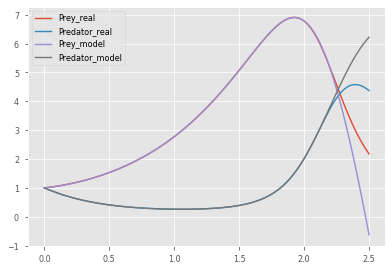

In [87]:
#Extrapolating
t_eval_2 = tf.linspace(0., 2.5, num=1000)  # Re-evaluate for 3 seconds of input and 1000 timesteps

with tf.device(device):
    model_results_2 = odeint(model, initial_states, t_eval_2)
    real_results_2 = odeint(LotkaVoltera(a, b, c, d), initial_states, t_eval_2)
    
plot_results(t_eval_2, real_results_2, labels=['Prey_real', 'Predator_real'])
plot_results(t_eval_2, model_results_2, labels=['Prey_model', 'Predator_model'])

In [88]:
real_results_np = real_results.numpy()
model_preds_np = model_results.numpy()
t_eval_np = t_eval.numpy()

In [89]:
from pysindy import SINDy
from pysindy import SR3
from pysindy.feature_library.polynomial_library import PolynomialLibrary

# Import this optimizer for Ridge regression !
from tfdiffeq.sindy_utils import STRRidge

In [90]:
sindy_optm = SR3(threshold=0.1, nu=1.0, max_iter=100)
sindy_library = PolynomialLibrary(degree=10, include_interaction=True,  interaction_only=True)

In [91]:
sindy_model = SINDy(optimizer=sindy_optm, feature_library=sindy_library, discrete_time=False)
sindy_model.fit(model_preds_np, t_eval_np)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=10, interaction_only=True),
      feature_names=['x0', 'x1'], optimizer=SR3(max_iter=100))

In [94]:
sindy_model.print()

x0' = 1.495 x0 + 0.001 x1 + -0.991 x0 x1
x1' = -2.994 x1 + 0.998 x0 x1


In [97]:
sindy_model.coefficients()

array([[ 0.00000000e+00,  1.49483932e+00,  1.16173652e-03,
        -9.91143220e-01],
       [ 0.00000000e+00,  0.00000000e+00, -2.99393691e+00,
         9.98355868e-01]])

In [98]:
sindy_model.score(model_preds_np, t_eval_np)

0.9997796602228386

In [101]:
a_dash = 1.49483932e+00
b_dash = 9.91143220e-01
c_dash = 2.99393691e+00
d_dash = 9.98355868e-01

t_extrapolate = tf.linspace(0., 10.0, num=1000) 
initial_states_extrapolate = tf.convert_to_tensor([1, 1], dtype=tf.float64)

with tf.device(device):
    extrapolation_model = LotkaVoltera(a_dash, b_dash, c_dash, d_dash)
    extrapolated_results = odeint(extrapolation_model, initial_states_extrapolate, t_extrapolate)
    real_results = odeint(LotkaVoltera(a, b, c, d), initial_states_extrapolate, t_extrapolate)

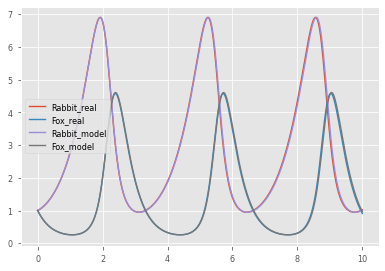

In [102]:
plot_results(t_extrapolate, real_results, labels=['Prey_real', 'Predator_real'])
plot_results(t_extrapolate, extrapolated_results, labels=['Prey_model', 'Predator_model'])